In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
matplotlib.rcParams['figure.figsize'] = (10, 5)
import pandas as pd
import math as m
from sklearn.metrics import f1_score, mean_absolute_error, mean_squared_error, accuracy_score

from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor  # Use XGBClassifier for classification tasks

In [2]:
data = "processed_dataset.csv"

DATA17 = "data/raw/Onsite-MetMast-SCADA-data-2017.xlsx"
DATAScada17 = "data/raw/Wind-Turbine-SCADA-signals-2017_0.xlsx"

data17 = pd.read_excel(DATA17, engine='openpyxl')
datascada17= pd.read_excel(DATAScada17, engine="openpyxl")

merged_df17 = pd.merge(datascada17, data17, on="Timestamp", how="inner")

In [3]:
#merged_df17.to_csv()

In [4]:
merged_df = pd.read_csv(data)

the csv file is a preprocessed file, which was processed using rules from analysis of the power production

scada data from 2017 needs to be preprocessed as well:
- t07 turbine should only be evaluated (see below)

In [5]:
#t07 is selected
merged_df17 = merged_df17[merged_df17["Turbine_ID"] == "T07"]

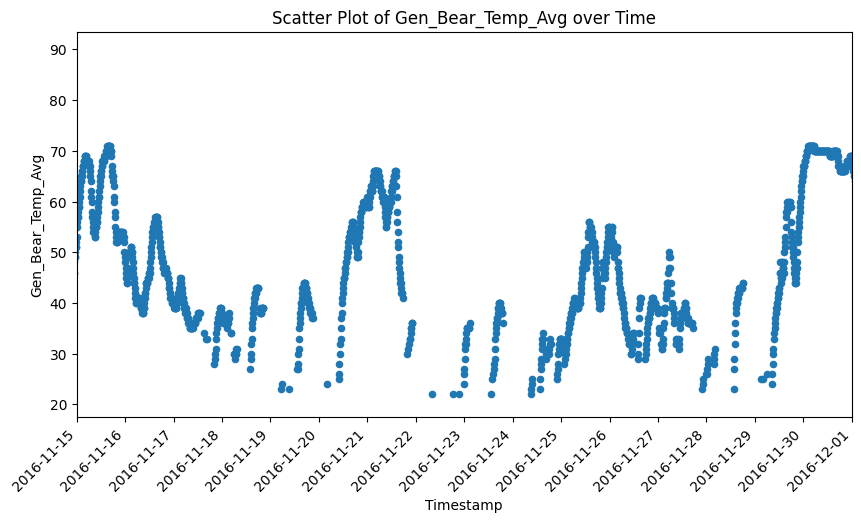

In [6]:
# plotting some data to look for outliers and anomalties in the data itself. Visualize the data
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#for i in merged_df:
merged_df['Timestamp'] = pd.to_datetime(merged_df['Timestamp'])

ax = merged_df.plot.scatter(x="Timestamp", y="Gen_Bear_Temp_Avg")

# Customize the format of the timestamp on the x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Optionally, set the locator for more control over tick placement
ax.xaxis.set_major_locator(mdates.DayLocator())  # You can adjust the locator based on your data frequency

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
#Define interval for data
plt.xlim(pd.Timestamp('2016-11-15'), pd.Timestamp('2016-12-01'))

# Add labels and title
plt.xlabel('Timestamp')
plt.ylabel('Gen_Bear_Temp_Avg')
plt.title('Scatter Plot of Gen_Bear_Temp_Avg over Time')

# Show the plot
plt.show()


In [7]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, accuracy_score

# Step 2: Specify the feature columns and the target variable
feature_columns = ["Gen_Phase1_Temp_Avg", "Gen_RPM_Avg", "Avg_Windspeed1", "Nac_Temp_Avg", "Avg_Humidity"]  # Features
target_column = 'Gen_Bear_Temp_Avg'  # Target variable

# Step 3: Prepare the training data from merged_df
X_train = merged_df[feature_columns]  # Feature set for training
y_train = merged_df[target_column]   # Target variable for training

# Step 4: Prepare the prediction data from merged_df17
X_test = merged_df17[feature_columns]  # Feature set for predictions

# Step 5: Initialize the XGBoost model
model = XGBRegressor()  # Use XGBClassifier() if it's a classification task

# Step 6: Train the model
model.fit(X_train, y_train)

# Step 7: Make predictions on the merged_df17 dataset
predictions = model.predict(X_test)

# Step 8: Evaluate the model on merged_df (Optional)
"""# This evaluation is only for the training dataset, not merged_df17
if isinstance(y_train, pd.Series) and y_train.nunique() <= 2:
    # If the target variable has two unique values, treat it as a classification problem
    train_predictions = model.predict(X_train)
    accuracy = accuracy_score(y_train, train_predictions.round())
    print(f'Accuracy on Training Data: {accuracy:.2f}')
else:
    # If it's a regression problem, calculate the mean squared error
    train_predictions = model.predict(X_train)
    mse = mean_squared_error(y_train, train_predictions)
    print(f'Mean Squared Error on Training Data: {mse:.2f}')"""

# Step 9: Store predictions in merged_df17
merged_df17["xgboost_pred_2017"] = predictions


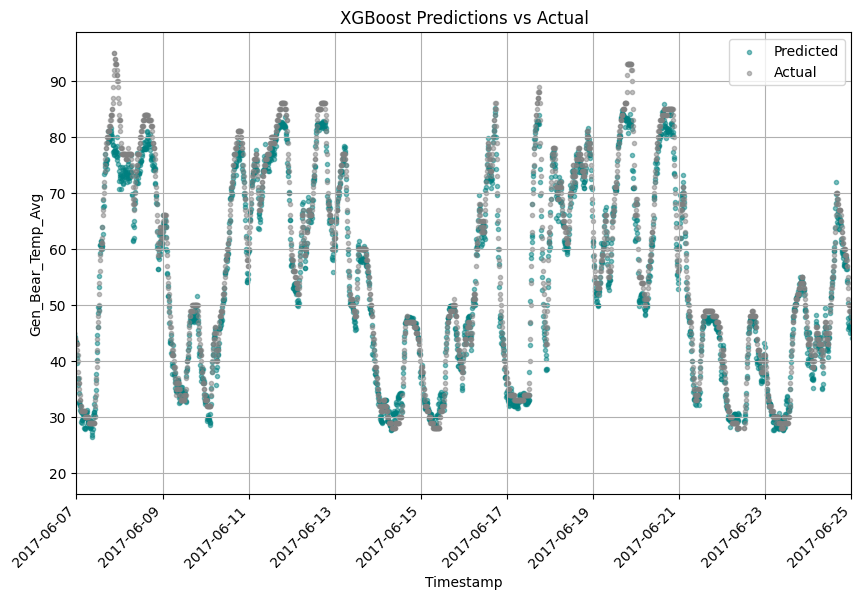

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df17["Timestamp"] = pd.to_datetime(merged_df17["Timestamp"])

# Sort merged_df17 by "Timestamp" for better visualization
merged_df_filtered17_sorted = merged_df17.sort_values(by="Timestamp")

plt.figure(figsize=(10, 6))

# Scatter plot for predicted values
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"],  # Sorted timestamps
    merged_df_filtered17_sorted["xgboost_pred_2017"],  # Predictions stored in 'cp_xgboost'
    c='teal', alpha=0.5, label='Predicted', marker="."
)

# Scatter plot for actual values (y_test)
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"],  # Sorted timestamps
    merged_df_filtered17_sorted[target_column],  # Actual target values
    c='grey', alpha=0.5, label='Actual', marker=".", 
)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for data (adjust as needed)
plt.xlim(pd.to_datetime('2017-06-07'), pd.to_datetime('2017-06-25'))

plt.title("XGBoost Predictions vs Actual")
plt.xlabel("Timestamp")
plt.ylabel(target_column)
plt.legend()  # Show legend to distinguish between predicted and actual values
plt.grid(True)
plt.show()


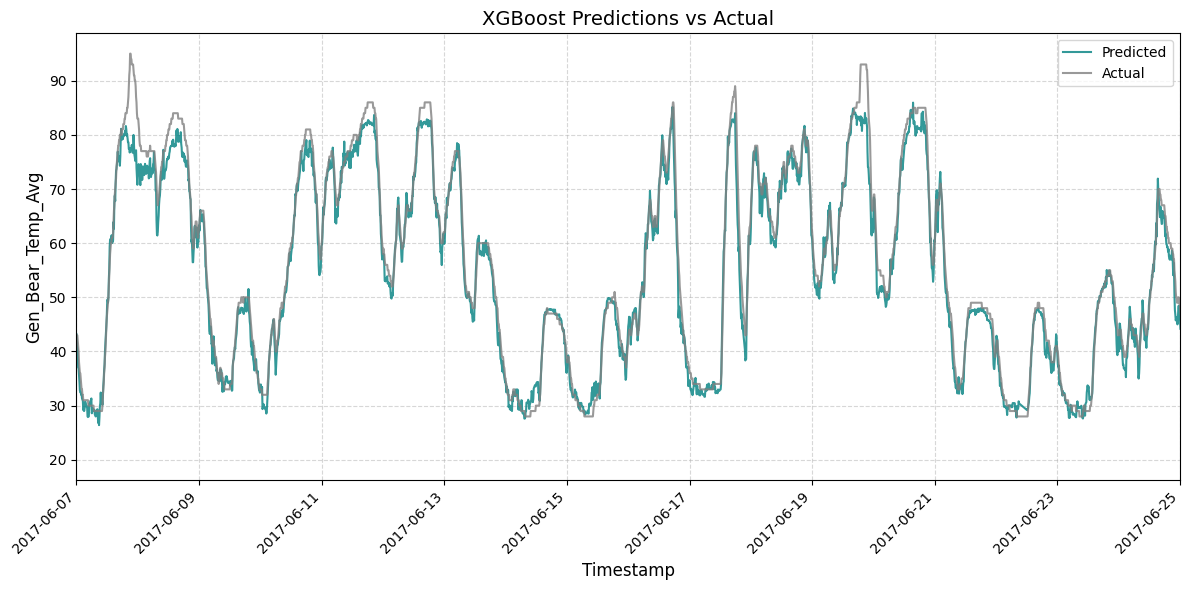

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df17["Timestamp"] = pd.to_datetime(merged_df17["Timestamp"])

# Sort merged_df17 by "Timestamp" for better visualization
merged_df_filtered17_sorted = merged_df17.sort_values(by="Timestamp")

plt.figure(figsize=(12, 6))

# Line plot for predicted values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"],  # Sorted timestamps
    merged_df_filtered17_sorted["xgboost_pred_2017"],  # Predictions
    color='teal', alpha=0.8, label='Predicted', linestyle='-', linewidth=1.5
)

# Line plot for actual values
plt.plot(
    merged_df_filtered17_sorted["Timestamp"],  # Sorted timestamps
    merged_df_filtered17_sorted[target_column],  # Actual target values
    color='grey', alpha=0.8, label='Actual', linestyle='-', linewidth=1.5
)

# Highlight x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for x-axis (adjust as needed)
plt.xlim(pd.to_datetime('2017-06-07'), pd.to_datetime('2017-06-25'))

# Title and labels
plt.title("XGBoost Predictions vs Actual", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


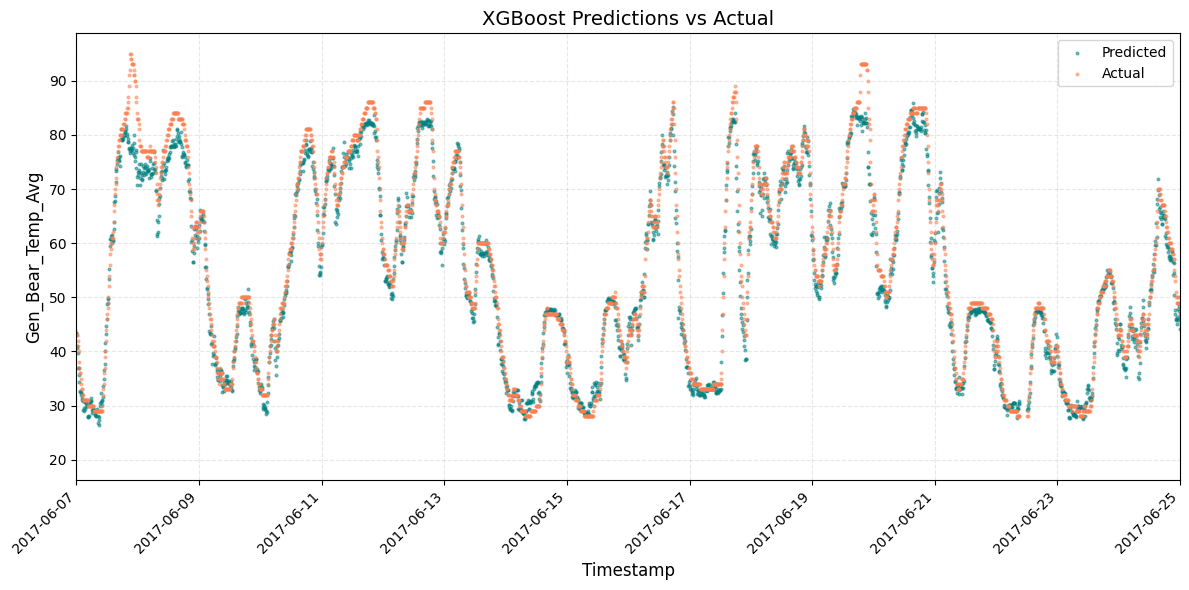

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure Timestamp column is in datetime format
merged_df17["Timestamp"] = pd.to_datetime(merged_df17["Timestamp"])

# Sort merged_df17 by "Timestamp" for better visualization
merged_df_filtered17_sorted = merged_df17.sort_values(by="Timestamp")

plt.figure(figsize=(12, 6))

# Scatter plot for predicted values
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"],  # Sorted timestamps
    merged_df_filtered17_sorted["xgboost_pred_2017"],  # Predictions
    c='teal', alpha=0.5, label='Predicted', marker='.', s=15  # Adjusted size and transparency
)

# Scatter plot for actual values
plt.scatter(
    merged_df_filtered17_sorted["Timestamp"],  # Sorted timestamps
    merged_df_filtered17_sorted[target_column],  # Actual target values
    c='coral', alpha=0.5, label='Actual', marker='.', s=15  # Different marker and transparency
)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Define interval for x-axis (adjust as needed)
plt.xlim(pd.to_datetime('2017-06-07'), pd.to_datetime('2017-06-25'))

# Title and labels
plt.title("XGBoost Predictions vs Actual", fontsize=14)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel(target_column, fontsize=12)

# Legend and grid for clarity
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.3)  # Subtle grid

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


In [11]:
merged_df_filtered17_sorted

Turbine_ID                 Timestamp  Gen_RPM_Max  Gen_RPM_Min  \
87615        T07 2017-01-01 00:00:00+00:00       1513.4       1255.3   
37433        T07 2017-01-01 00:10:00+00:00       1485.4       1243.1   
54937        T07 2017-01-01 00:20:00+00:00       1505.3       1255.1   
87608        T07 2017-01-01 00:30:00+00:00       1486.6       1246.1   
19102        T07 2017-01-01 00:40:00+00:00       1381.6       1241.4   
...          ...                       ...          ...          ...   
729          T07 2017-12-31 23:10:00+00:00       1576.2       1253.8   
734          T07 2017-12-31 23:20:00+00:00       1577.7       1231.2   
29823        T07 2017-12-31 23:30:00+00:00       1282.8       1232.5   
738          T07 2017-12-31 23:40:00+00:00       1269.8       1230.8   
65839        T07 2017-12-31 23:50:00+00:00       1329.9       1193.0   

       Gen_RPM_Avg  Gen_RPM_Std  Gen_Bear_Temp_Avg  Gen_Phase1_Temp_Avg  \
87615       1336.5         47.6               36.0                   58   
37433       1307.9         34.7               36.0                   58   
54937       1325.9         41.4               36.0                   58   
87608       1322.4         44.7               36.0                   58   
19102       1292.4         31.1               36.0                   58   
...            ...          ...                ...                  ...   
729         1387.4         79.7               39.0                   64   
734         1343.0         87.5               39.0                   63   
29823       1250.7          8.5               38.0                   63   
738         1250.2          6.9               38.0                   62   
65839       1257.6         18.9               38.0                   61   

       Gen_Phase2_Temp_Avg  Gen_Phase3_Temp_Avg  ...  Anemometer2_Freq  \
87615                   58                   58  ...            0.0499   
37433                   58                   58  ...            0.0499   
54937                   58                   58  ...            0.0499   
87608                   58                   58  ...            0.0499   
19102                   58                   58  ...            0.0499   
...                    ...                  ...  ...               ...   
729                     64                   63  ...            0.0499   
734                     63                   63  ...            0.0499   
29823                   63                   62  ...            0.0499   
738                     62                   61  ...            0.0499   
65839                   61                   61  ...            0.0499   

       Anemometer2_Offset  Anemometer2_CorrGain  Anemometer2_CorrOffset  \
87615                0.24                     1                       0   
37433                0.24                     1                       0   
54937                0.24                     1                       0   
87608                0.24                     1                       0   
19102                0.24                     1                       0   
...                   ...                   ...                     ...   
729                  0.24                     1                       0   
734                  0.24                     1                       0   
29823                0.24                     1                       0   
738                  0.24                     1                       0   
65839                0.24                     1                       0   

       DistanceAirPress  AirRessureSensorZeroOffset  Anemometer1_Avg_Freq  \
87615                 0                         600                   156   
37433                 0                         600                   148   
54937                 0                         600                   151   
87608                 0                         600                   157   
19102                 0                         600              

In [12]:
merged_df_filtered17_sorted

Turbine_ID                 Timestamp  Gen_RPM_Max  Gen_RPM_Min  \
87615        T07 2017-01-01 00:00:00+00:00       1513.4       1255.3   
37433        T07 2017-01-01 00:10:00+00:00       1485.4       1243.1   
54937        T07 2017-01-01 00:20:00+00:00       1505.3       1255.1   
87608        T07 2017-01-01 00:30:00+00:00       1486.6       1246.1   
19102        T07 2017-01-01 00:40:00+00:00       1381.6       1241.4   
...          ...                       ...          ...          ...   
729          T07 2017-12-31 23:10:00+00:00       1576.2       1253.8   
734          T07 2017-12-31 23:20:00+00:00       1577.7       1231.2   
29823        T07 2017-12-31 23:30:00+00:00       1282.8       1232.5   
738          T07 2017-12-31 23:40:00+00:00       1269.8       1230.8   
65839        T07 2017-12-31 23:50:00+00:00       1329.9       1193.0   

       Gen_RPM_Avg  Gen_RPM_Std  Gen_Bear_Temp_Avg  Gen_Phase1_Temp_Avg  \
87615       1336.5         47.6               36.0                   58   
37433       1307.9         34.7               36.0                   58   
54937       1325.9         41.4               36.0                   58   
87608       1322.4         44.7               36.0                   58   
19102       1292.4         31.1               36.0                   58   
...            ...          ...                ...                  ...   
729         1387.4         79.7               39.0                   64   
734         1343.0         87.5               39.0                   63   
29823       1250.7          8.5               38.0                   63   
738         1250.2          6.9               38.0                   62   
65839       1257.6         18.9               38.0                   61   

       Gen_Phase2_Temp_Avg  Gen_Phase3_Temp_Avg  ...  Anemometer2_Freq  \
87615                   58                   58  ...            0.0499   
37433                   58                   58  ...            0.0499   
54937                   58                   58  ...            0.0499   
87608                   58                   58  ...            0.0499   
19102                   58                   58  ...            0.0499   
...                    ...                  ...  ...               ...   
729                     64                   63  ...            0.0499   
734                     63                   63  ...            0.0499   
29823                   63                   62  ...            0.0499   
738                     62                   61  ...            0.0499   
65839                   61                   61  ...            0.0499   

       Anemometer2_Offset  Anemometer2_CorrGain  Anemometer2_CorrOffset  \
87615                0.24                     1                       0   
37433                0.24                     1                       0   
54937                0.24                     1                       0   
87608                0.24                     1                       0   
19102                0.24                     1                       0   
...                   ...                   ...                     ...   
729                  0.24                     1                       0   
734                  0.24                     1                       0   
29823                0.24                     1                       0   
738                  0.24                     1                       0   
65839                0.24                     1                       0   

       DistanceAirPress  AirRessureSensorZeroOffset  Anemometer1_Avg_Freq  \
87615                 0                         600                   156   
37433                 0                         600                   148   
54937                 0                         600                   151   
87608                 0                         600                   157   
19102                 0                         600              

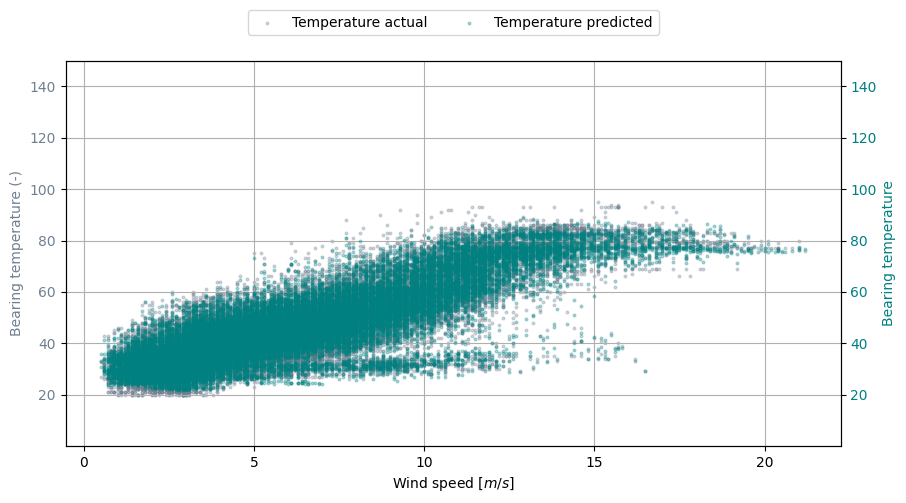

In [13]:
# Adjusted color scheme with burgundy and muted green
fig, ax1 = plt.subplots()  # Create a figure and axis

# Plotting the actual Cp values on the primary y-axis with burgundy
ax1.scatter(merged_df_filtered17_sorted["Amb_WindSpeed_Avg"], merged_df_filtered17_sorted["Gen_Bear_Temp_Avg"], color='slategrey', label='Temperature actual', alpha=0.3, marker='.', s=15)
ax1.set_xlabel('Wind speed [$m/s$]')  # x-axis label
ax1.set_ylabel('Bearing temperature (-)', color='slategrey')  # Primary y-axis label color
ax1.tick_params(axis='y', labelcolor='slategrey')  # Primary y-axis label tick color
ax1.grid()
ax1.set_ylim(0.1, 150)  # Set y-limits for Cp values

# Create a secondary y-axis with a muted green color
ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis
ax2.scatter(merged_df_filtered17_sorted["Amb_WindSpeed_Avg"], merged_df_filtered17_sorted["xgboost_pred_2017"], color='teal', label='Temperature predicted', alpha=0.3, marker='.', s=15)  # Muted olive green color
ax2.set_ylabel('Bearing temperature', color='teal')  # Secondary y-axis label color
ax2.tick_params(axis='y', labelcolor='teal')  # Secondary y-axis label tick color
ax2.set_ylim(0.1, 150)

# Optional: Add legends for both y-axes with subtle colors
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), bbox_transform=ax1.transAxes, ncol=2)

# Show the plot
plt.show()

# Intervals:

In [14]:
# check units of the independent variables to make sure that interval is correctly chosen:
["Gen_Phase1_Temp_Avg", "Gen_RPM_Avg", "Avg_Windspeed1", "Nac_Temp_Avg", "Avg_Humidity"]
# Get a statistical summary for the other columns

windspeed_summary = merged_df_filtered17_sorted["Avg_Windspeed1"].describe()
nac_temp_summary = merged_df_filtered17_sorted["Nac_Temp_Avg"].describe()
humidity_summary = merged_df_filtered17_sorted["Avg_Humidity"].describe()
print(f"Avg Windspeed Summary:\n{windspeed_summary}")
print(f"Nac Temp Avg Summary:\n{nac_temp_summary}")
print(f"Avg Humidity Summary:\n{humidity_summary}")


Avg Windspeed Summary:
count    34581.000000
mean         6.257465
std          3.527416
min          0.000000
25%          3.600000
50%          5.600000
75%          8.400000
max         23.100000
Name: Avg_Windspeed1, dtype: float64
Nac Temp Avg Summary:
count    34582.000000
mean        31.666994
std          5.829491
min         17.000000
25%         28.000000
50%         32.000000
75%         36.000000
max         50.000000
Name: Nac_Temp_Avg, dtype: float64
Avg Humidity Summary:
count    34582.000000
mean        63.366694
std         17.430912
min         11.000000
25%         51.000000
50%         65.000000
75%         77.000000
max         99.000000
Name: Avg_Humidity, dtype: float64


In [15]:
humidity_interval = [-1,1]          # percentage? 
Gen_Phase1_Temp_interval = [-1,1]   # degrees
Gen_RPM_interval = [-1,1]           # RPM
Windspeed1_interval = [-1,1]        # m/s
Nac_Temp_interval = [-1,1]          # celcius

In [16]:
# Create and calculate 'max' columns using the average values and max of intervals
merged_df_filtered17_sorted["max_Humidity"] = merged_df_filtered17_sorted["Avg_Humidity"] + max(humidity_interval)
merged_df_filtered17_sorted["max_Gen_Phase1_Temp"] = merged_df_filtered17_sorted["Gen_Phase1_Temp_Avg"] + max(Gen_Phase1_Temp_interval)
merged_df_filtered17_sorted["max_Gen_RPM"] = merged_df_filtered17_sorted["Gen_RPM_Avg"] + max(Gen_RPM_interval)
merged_df_filtered17_sorted["max_Windspeed1"] = merged_df_filtered17_sorted["Avg_Windspeed1"] + max(Windspeed1_interval)
merged_df_filtered17_sorted["max_Nac_Temp"] = merged_df_filtered17_sorted["Nac_Temp_Avg"] + max(Nac_Temp_interval)

# Create and calculate 'min' columns using the average values and min of intervals
merged_df_filtered17_sorted["min_Humidity"] = merged_df_filtered17_sorted["Avg_Humidity"] + min(humidity_interval)
merged_df_filtered17_sorted["min_Gen_Phase1_Temp"] = merged_df_filtered17_sorted["Gen_Phase1_Temp_Avg"] + min(Gen_Phase1_Temp_interval)
merged_df_filtered17_sorted["min_Gen_RPM"] = merged_df_filtered17_sorted["Gen_RPM_Avg"] + min(Gen_RPM_interval)
merged_df_filtered17_sorted["min_Windspeed1"] = merged_df_filtered17_sorted["Avg_Windspeed1"] + min(Windspeed1_interval)
merged_df_filtered17_sorted["min_Nac_Temp"] = merged_df_filtered17_sorted["Nac_Temp_Avg"] + min(Nac_Temp_interval)


In [17]:
"""# Lists of the interval names marked with "Min" and "Max"
min_names = [
    "Avg_Windspeed1", "Gen_Phase1_Temp_Avg", "Avg_Humidity",  # Combination 1, 2, 3, 4
    "Gen_RPM_Avg", "Nac_Temp_Avg"  # Continue this list for other combinations
]

max_names = [
    "Avg_Windspeed1", "Gen_Phase1_Temp_Avg", "Avg_Humidity",  # Combination 5, 6, 7, 8
    "Gen_RPM_Avg", "Nac_Temp_Avg"  # Continue this list for other combinations
]
"""

'# Lists of the interval names marked with "Min" and "Max"\nmin_names = [\n    "Avg_Windspeed1", "Gen_Phase1_Temp_Avg", "Avg_Humidity",  # Combination 1, 2, 3, 4\n    "Gen_RPM_Avg", "Nac_Temp_Avg"  # Continue this list for other combinations\n]\n\nmax_names = [\n    "Avg_Windspeed1", "Gen_Phase1_Temp_Avg", "Avg_Humidity",  # Combination 5, 6, 7, 8\n    "Gen_RPM_Avg", "Nac_Temp_Avg"  # Continue this list for other combinations\n]\n'

In [18]:
"""# Define the combinations as per the table, mapping 'Min' and 'Max' for each feature
combination_configs = {
    1: {"Avg_Windspeed1": "Min", "Gen_Phase1_Temp_Avg": "Min", "Avg_Humidity": "Min", "Gen_RPM_Avg": "Min", "Nac_Temp_Avg": "Min"},
    2: {"Avg_Windspeed1": "Min", "Gen_Phase1_Temp_Avg": "Min", "Avg_Humidity": "Min", "Gen_RPM_Avg": "Min", "Nac_Temp_Avg": "Max"},
    3: {"Avg_Windspeed1": "Min", "Gen_Phase1_Temp_Avg": "Min", "Avg_Humidity": "Max", "Gen_RPM_Avg": "Min", "Nac_Temp_Avg": "Min"},
    4: {"Avg_Windspeed1": "Min", "Gen_Phase1_Temp_Avg": "Min", "Avg_Humidity": "Max", "Gen_RPM_Avg": "Max", "Nac_Temp_Avg": "Min"},
    5: {"Avg_Windspeed1": "Min", "Gen_Phase1_Temp_Avg": "Max", "Avg_Humidity": "Min", "Gen_RPM_Avg": "Min", "Nac_Temp_Avg": "Min"},
    6: {"Avg_Windspeed1": "Min", "Gen_Phase1_Temp_Avg": "Max", "Avg_Humidity": "Min", "Gen_RPM_Avg": "Max", "Nac_Temp_Avg": "Min"},
    7: {"Avg_Windspeed1": "Min", "Gen_Phase1_Temp_Avg": "Max", "Avg_Humidity": "Max", "Gen_RPM_Avg": "Min", "Nac_Temp_Avg": "Min"},
    8: {"Avg_Windspeed1": "Min", "Gen_Phase1_Temp_Avg": "Max", "Avg_Humidity": "Max", "Gen_RPM_Avg": "Max", "Nac_Temp_Avg": "Min"},
    9: {"Avg_Windspeed1": "Max", "Gen_Phase1_Temp_Avg": "Min", "Avg_Humidity": "Min", "Gen_RPM_Avg": "Min", "Nac_Temp_Avg": "Min"},
    10: {"Avg_Windspeed1": "Max", "Gen_Phase1_Temp_Avg": "Min", "Avg_Humidity": "Min", "Gen_RPM_Avg": "Max", "Nac_Temp_Avg": "Min"},
    11: {"Avg_Windspeed1": "Max", "Gen_Phase1_Temp_Avg": "Min", "Avg_Humidity": "Max", "Gen_RPM_Avg": "Min", "Nac_Temp_Avg": "Min"},
    12: {"Avg_Windspeed1": "Max", "Gen_Phase1_Temp_Avg": "Min", "Avg_Humidity": "Max", "Gen_RPM_Avg": "Max", "Nac_Temp_Avg": "Min"},
    13: {"Avg_Windspeed1": "Max", "Gen_Phase1_Temp_Avg": "Max", "Avg_Humidity": "Min", "Gen_RPM_Avg": "Min", "Nac_Temp_Avg": "Min"},
    14: {"Avg_Windspeed1": "Max", "Gen_Phase1_Temp_Avg": "Max", "Avg_Humidity": "Min", "Gen_RPM_Avg": "Max", "Nac_Temp_Avg": "Min"},
    15: {"Avg_Windspeed1": "Max", "Gen_Phase1_Temp_Avg": "Max", "Avg_Humidity": "Max", "Gen_RPM_Avg": "Min", "Nac_Temp_Avg": "Min"},
    16: {"Avg_Windspeed1": "Max", "Gen_Phase1_Temp_Avg": "Max", "Avg_Humidity": "Max", "Gen_RPM_Avg": "Max", "Nac_Temp_Avg": "Max"}
}
"""

'# Define the combinations as per the table, mapping \'Min\' and \'Max\' for each feature\ncombination_configs = {\n    1: {"Avg_Windspeed1": "Min", "Gen_Phase1_Temp_Avg": "Min", "Avg_Humidity": "Min", "Gen_RPM_Avg": "Min", "Nac_Temp_Avg": "Min"},\n    2: {"Avg_Windspeed1": "Min", "Gen_Phase1_Temp_Avg": "Min", "Avg_Humidity": "Min", "Gen_RPM_Avg": "Min", "Nac_Temp_Avg": "Max"},\n    3: {"Avg_Windspeed1": "Min", "Gen_Phase1_Temp_Avg": "Min", "Avg_Humidity": "Max", "Gen_RPM_Avg": "Min", "Nac_Temp_Avg": "Min"},\n    4: {"Avg_Windspeed1": "Min", "Gen_Phase1_Temp_Avg": "Min", "Avg_Humidity": "Max", "Gen_RPM_Avg": "Max", "Nac_Temp_Avg": "Min"},\n    5: {"Avg_Windspeed1": "Min", "Gen_Phase1_Temp_Avg": "Max", "Avg_Humidity": "Min", "Gen_RPM_Avg": "Min", "Nac_Temp_Avg": "Min"},\n    6: {"Avg_Windspeed1": "Min", "Gen_Phase1_Temp_Avg": "Max", "Avg_Humidity": "Min", "Gen_RPM_Avg": "Max", "Nac_Temp_Avg": "Min"},\n    7: {"Avg_Windspeed1": "Min", "Gen_Phase1_Temp_Avg": "Max", "Avg_Humidity": "Max", 

In [19]:
"""import pandas as pd
from xgboost import XGBRegressor

# Define the feature intervals
humidity_interval = [-1, 1]
Gen_Phase1_Temp_interval = [-1, 1]
Gen_RPM_interval = [-1, 1]
Windspeed1_interval = [-1, 1]
Nac_Temp_interval = [-1, 1]

# Create 'max' and 'min' columns for each feature based on the intervals
merged_df_filtered17_sorted["max_Humidity"] = merged_df_filtered17_sorted["Avg_Humidity"] + max(humidity_interval)
merged_df_filtered17_sorted["max_Gen_Phase1_Temp"] = merged_df_filtered17_sorted["Gen_Phase1_Temp_Avg"] + max(Gen_Phase1_Temp_interval)
merged_df_filtered17_sorted["max_Gen_RPM"] = merged_df_filtered17_sorted["Gen_RPM_Avg"] + max(Gen_RPM_interval)
merged_df_filtered17_sorted["max_Windspeed1"] = merged_df_filtered17_sorted["Avg_Windspeed1"] + max(Windspeed1_interval)
merged_df_filtered17_sorted["max_Nac_Temp"] = merged_df_filtered17_sorted["Nac_Temp_Avg"] + max(Nac_Temp_interval)

# Create 'min' columns for each feature based on the intervals
merged_df_filtered17_sorted["min_Humidity"] = merged_df_filtered17_sorted["Avg_Humidity"] + min(humidity_interval)
merged_df_filtered17_sorted["min_Gen_Phase1_Temp"] = merged_df_filtered17_sorted["Gen_Phase1_Temp_Avg"] + min(Gen_Phase1_Temp_interval)
merged_df_filtered17_sorted["min_Gen_RPM"] = merged_df_filtered17_sorted["Gen_RPM_Avg"] + min(Gen_RPM_interval)
merged_df_filtered17_sorted["min_Windspeed1"] = merged_df_filtered17_sorted["Avg_Windspeed1"] + min(Windspeed1_interval)
merged_df_filtered17_sorted["min_Nac_Temp"] = merged_df_filtered17_sorted["Nac_Temp_Avg"] + min(Nac_Temp_interval)

# Define the feature columns
feature_columns = ["Gen_Phase1_Temp_Avg", "Gen_RPM_Avg", "Avg_Windspeed1", "Nac_Temp_Avg", "Avg_Humidity"]

# Load your trained model (already assumed to be available as `model` in the notebook)
# Example: model = XGBRegressor()
# model.fit(X_train, y_train)  # Model is already trained

# Generate the combinations of 'min' and 'max' for each feature
combinations = [
    ("min_Windspeed1", "min_Gen_Phase1_Temp", "min_Gen_RPM", "min_Nac_Temp", "min_Humidity"),
    ("min_Windspeed1", "min_Gen_Phase1_Temp", "min_Gen_RPM", "min_Nac_Temp", "max_Humidity"),
    ("min_Windspeed1", "min_Gen_Phase1_Temp", "min_Gen_RPM", "max_Nac_Temp", "min_Humidity"),
    ("min_Windspeed1", "min_Gen_Phase1_Temp", "min_Gen_RPM", "max_Nac_Temp", "max_Humidity"),
    ("min_Windspeed1", "min_Gen_Phase1_Temp", "max_Gen_RPM", "min_Nac_Temp", "min_Humidity"),
    ("min_Windspeed1", "min_Gen_Phase1_Temp", "max_Gen_RPM", "min_Nac_Temp", "max_Humidity"),
    ("min_Windspeed1", "min_Gen_Phase1_Temp", "max_Gen_RPM", "max_Nac_Temp", "min_Humidity"),
    ("min_Windspeed1", "min_Gen_Phase1_Temp", "max_Gen_RPM", "max_Nac_Temp", "max_Humidity"),
    ("min_Windspeed1", "max_Gen_Phase1_Temp", "min_Gen_RPM", "min_Nac_Temp", "min_Humidity"),
    ("min_Windspeed1", "max_Gen_Phase1_Temp", "min_Gen_RPM", "min_Nac_Temp", "max_Humidity"),
    ("min_Windspeed1", "max_Gen_Phase1_Temp", "min_Gen_RPM", "max_Nac_Temp", "min_Humidity"),
    ("min_Windspeed1", "max_Gen_Phase1_Temp", "min_Gen_RPM", "max_Nac_Temp", "max_Humidity"),
    ("max_Windspeed1", "min_Gen_Phase1_Temp", "min_Gen_RPM", "min_Nac_Temp", "min_Humidity"),
    ("max_Windspeed1", "min_Gen_Phase1_Temp", "min_Gen_RPM", "min_Nac_Temp", "max_Humidity"),
    ("max_Windspeed1", "min_Gen_Phase1_Temp", "min_Gen_RPM", "max_Nac_Temp", "min_Humidity"),
    ("max_Windspeed1", "min_Gen_Phase1_Temp", "min_Gen_RPM", "max_Nac_Temp", "max_Humidity"),
]

# Generate predictions for each combination
for i, combination in enumerate(combinations, 1):
    # Apply the combination configuration
    temp_df = merged_df_filtered17_sorted.copy()
    for feature, value in zip(feature_columns, combination):
        temp_df[feature] = temp_df[value]  # Apply the 'min' or 'max' value for each feature
    
    # Predict the target using the model for this combination
    merged_df_filtered17_sorted[f"combination_{i}"] = model.predict(temp_df[feature_columns])

# Now, merged_df_filtered17_sorted will have columns 'combination_1', 'combination_2', ..., 'combination_16'
"""

'import pandas as pd\nfrom xgboost import XGBRegressor\n\n# Define the feature intervals\nhumidity_interval = [-1, 1]\nGen_Phase1_Temp_interval = [-1, 1]\nGen_RPM_interval = [-1, 1]\nWindspeed1_interval = [-1, 1]\nNac_Temp_interval = [-1, 1]\n\n# Create \'max\' and \'min\' columns for each feature based on the intervals\nmerged_df_filtered17_sorted["max_Humidity"] = merged_df_filtered17_sorted["Avg_Humidity"] + max(humidity_interval)\nmerged_df_filtered17_sorted["max_Gen_Phase1_Temp"] = merged_df_filtered17_sorted["Gen_Phase1_Temp_Avg"] + max(Gen_Phase1_Temp_interval)\nmerged_df_filtered17_sorted["max_Gen_RPM"] = merged_df_filtered17_sorted["Gen_RPM_Avg"] + max(Gen_RPM_interval)\nmerged_df_filtered17_sorted["max_Windspeed1"] = merged_df_filtered17_sorted["Avg_Windspeed1"] + max(Windspeed1_interval)\nmerged_df_filtered17_sorted["max_Nac_Temp"] = merged_df_filtered17_sorted["Nac_Temp_Avg"] + max(Nac_Temp_interval)\n\n# Create \'min\' columns for each feature based on the intervals\nmerge

In [20]:
print(model.get_booster().feature_names)

['Gen_Phase1_Temp_Avg', 'Gen_RPM_Avg', 'Avg_Windspeed1', 'Nac_Temp_Avg', 'Avg_Humidity']


In [30]:
import pandas as pd
import itertools

# Define the intervals
humidity_interval = [-1, 1]         # percentage
Gen_Phase1_Temp_interval = [-1, 1]  # degrees
Gen_RPM_interval = [-1, 1]         # RPM
Windspeed1_interval = [-1, 1]      # m/s
Nac_Temp_interval = [-1, 1]        # Celsius

# Generate all 32 combinations of interval adjustments
combinations = list(itertools.product(
    humidity_interval,
    Gen_Phase1_Temp_interval,
    Gen_RPM_interval,
    Windspeed1_interval,
    Nac_Temp_interval
))

# Iterate through the 32 combinations
for idx, combo in enumerate(combinations):
    humidity_val, Gen_Phase1_Temp_val, Gen_RPM_val, Windspeed_val, Nac_Temp_val = combo

    # Apply the combination adjustments to the time series
    X_test = pd.DataFrame({
        'Gen_Phase1_Temp_Avg': merged_df_filtered17_sorted["Gen_Phase1_Temp_Avg"] + Gen_Phase1_Temp_val,
        'Gen_RPM_Avg': merged_df_filtered17_sorted["Gen_RPM_Avg"] + Gen_RPM_val,
        'Avg_Windspeed1': merged_df_filtered17_sorted["Avg_Windspeed1"] + Windspeed_val,
        'Nac_Temp_Avg': merged_df_filtered17_sorted["Nac_Temp_Avg"] + Nac_Temp_val,
        'Avg_Humidity': merged_df_filtered17_sorted["Avg_Humidity"] + humidity_val
    })

    # Predict with the model for the entire time series
    predictions = model.predict(X_test)

    # Store predictions in the DataFrame
    merged_df_filtered17_sorted[f'pred_comb_{idx+1}'] = predictions

    print(f"Combination {idx+1}: Prediction completed for the entire time series.")

# Optionally, you can save or visualize the modified DataFrame
# For example:
# merged_df_filtered17_sorted.to_csv('predictions_with_combinations.csv', index=False)


Combination 1: Prediction completed for the entire time series.
Combination 2: Prediction completed for the entire time series.
Combination 3: Prediction completed for the entire time series.
Combination 4: Prediction completed for the entire time series.
Combination 5: Prediction completed for the entire time series.
Combination 6: Prediction completed for the entire time series.
Combination 7: Prediction completed for the entire time series.
Combination 8: Prediction completed for the entire time series.
Combination 9: Prediction completed for the entire time series.
Combination 10: Prediction completed for the entire time series.
Combination 11: Prediction completed for the entire time series.
Combination 12: Prediction completed for the entire time series.
Combination 13: Prediction completed for the entire time series.
Combination 14: Prediction completed for the entire time series.
Combination 15: Prediction completed for the entire time series.
Combination 16: Prediction complet

In [21]:
# Define the 'min' and 'max' columns
min_columns = ["min_Humidity", "min_Gen_Phase1_Temp", "min_Gen_RPM", "min_Windspeed1", "min_Nac_Temp"]
max_columns = ["max_Humidity", "max_Gen_Phase1_Temp", "max_Gen_RPM", "max_Windspeed1", "max_Nac_Temp"]

# Generate all 32 combinations of 'min' and 'max' features
combinations = []
for i in range(32):
    combination = []
    for j in range(5):
        if (i >> j) & 1:
            combination.append(max_columns[j])  # Use max for this feature
        else:
            combination.append(min_columns[j])  # Use min for this feature
    combinations.append(combination)

# Ensure the correct feature order for the model
feature_columns = ["Gen_Phase1_Temp_Avg", "Gen_RPM_Avg", "Avg_Windspeed1", "Nac_Temp_Avg", "Avg_Humidity"]

# Predict for each combination
for idx, comb in enumerate(combinations, 1):
    # Prepare feature set for the current combination
    combination_features = merged_df_filtered17_sorted[comb].copy()
    
    # Rename columns to match the correct feature names and order
    combination_features.columns = feature_columns
    
    # Reorder columns to ensure proper order (optional, but ensures consistency)
    combination_features = combination_features[feature_columns]
    
    # Generate predictions for the current combination
    predictions = model.predict(combination_features)
    
    # Add predictions to the DataFrame as a new column
    merged_df_filtered17_sorted[f"combination_{idx}_prediction"] = predictions

# Check results
print(merged_df_filtered17_sorted.head())


      Turbine_ID                 Timestamp  Gen_RPM_Max  Gen_RPM_Min  \
87615        T07 2017-01-01 00:00:00+00:00       1513.4       1255.3   
37433        T07 2017-01-01 00:10:00+00:00       1485.4       1243.1   
54937        T07 2017-01-01 00:20:00+00:00       1505.3       1255.1   
87608        T07 2017-01-01 00:30:00+00:00       1486.6       1246.1   
19102        T07 2017-01-01 00:40:00+00:00       1381.6       1241.4   

       Gen_RPM_Avg  Gen_RPM_Std  Gen_Bear_Temp_Avg  Gen_Phase1_Temp_Avg  \
87615       1336.5         47.6               36.0                   58   
37433       1307.9         34.7               36.0                   58   
54937       1325.9         41.4               36.0                   58   
87608       1322.4         44.7               36.0                   58   
19102       1292.4         31.1               36.0                   58   

       Gen_Phase2_Temp_Avg  Gen_Phase3_Temp_Avg  ...  \
87615                   58                   58  ...   
3743

In [22]:
# Ensure correct feature order for predictions
feature_columns = ["Gen_Phase1_Temp_Avg", "Gen_RPM_Avg", "Avg_Windspeed1", "Nac_Temp_Avg", "Avg_Humidity"]

# Verify the range of min and max columns
for col in min_columns + max_columns:
    print(f"{col} - Min: {merged_df_filtered17_sorted[col].min()}, Max: {merged_df_filtered17_sorted[col].max()}")

# Predict for each combination
for idx, comb in enumerate(combinations, 1):
    # Prepare feature set for the current combination
    combination_features = merged_df_filtered17_sorted[comb].copy()
    
    # Rename columns to match the correct feature names and order
    combination_features.columns = feature_columns
    
    # Ensure alignment of feature columns with the model's expectations
    combination_features = combination_features[feature_columns]
    
    # Debug: Check the range of features before prediction
    print(f"Combination {idx} - Feature ranges:")
    print(combination_features.describe())
    
    # Generate predictions
    predictions = model.predict(combination_features)
    
    # Add predictions to the DataFrame
    merged_df_filtered17_sorted[f"combination_{idx}_prediction"] = predictions

# Plot the adjusted predictions against actual data (optional)


min_Humidity - Min: 10, Max: 98
min_Gen_Phase1_Temp - Min: 23, Max: 144
min_Gen_RPM - Min: -1.0, Max: 1682.8
min_Windspeed1 - Min: -1.0, Max: 22.1
min_Nac_Temp - Min: 16, Max: 49
max_Humidity - Min: 12, Max: 100
max_Gen_Phase1_Temp - Min: 25, Max: 146
max_Gen_RPM - Min: 1.0, Max: 1684.8
max_Windspeed1 - Min: 1.0, Max: 24.1
max_Nac_Temp - Min: 18, Max: 51
Combination 1 - Feature ranges:
       Gen_Phase1_Temp_Avg   Gen_RPM_Avg  Avg_Windspeed1  Nac_Temp_Avg  \
count         34582.000000  34582.000000    34582.000000  34581.000000   
mean             62.366694     67.326933     1066.409869      5.257465   
std              17.430912     29.825126      611.287551      3.527416   
min              10.000000     23.000000       -1.000000     -1.000000   
25%              50.000000     44.000000      282.000000      2.600000   
50%              64.000000     63.000000     1265.600000      4.600000   
75%              76.000000     81.000000     1602.500000      7.400000   
max              98

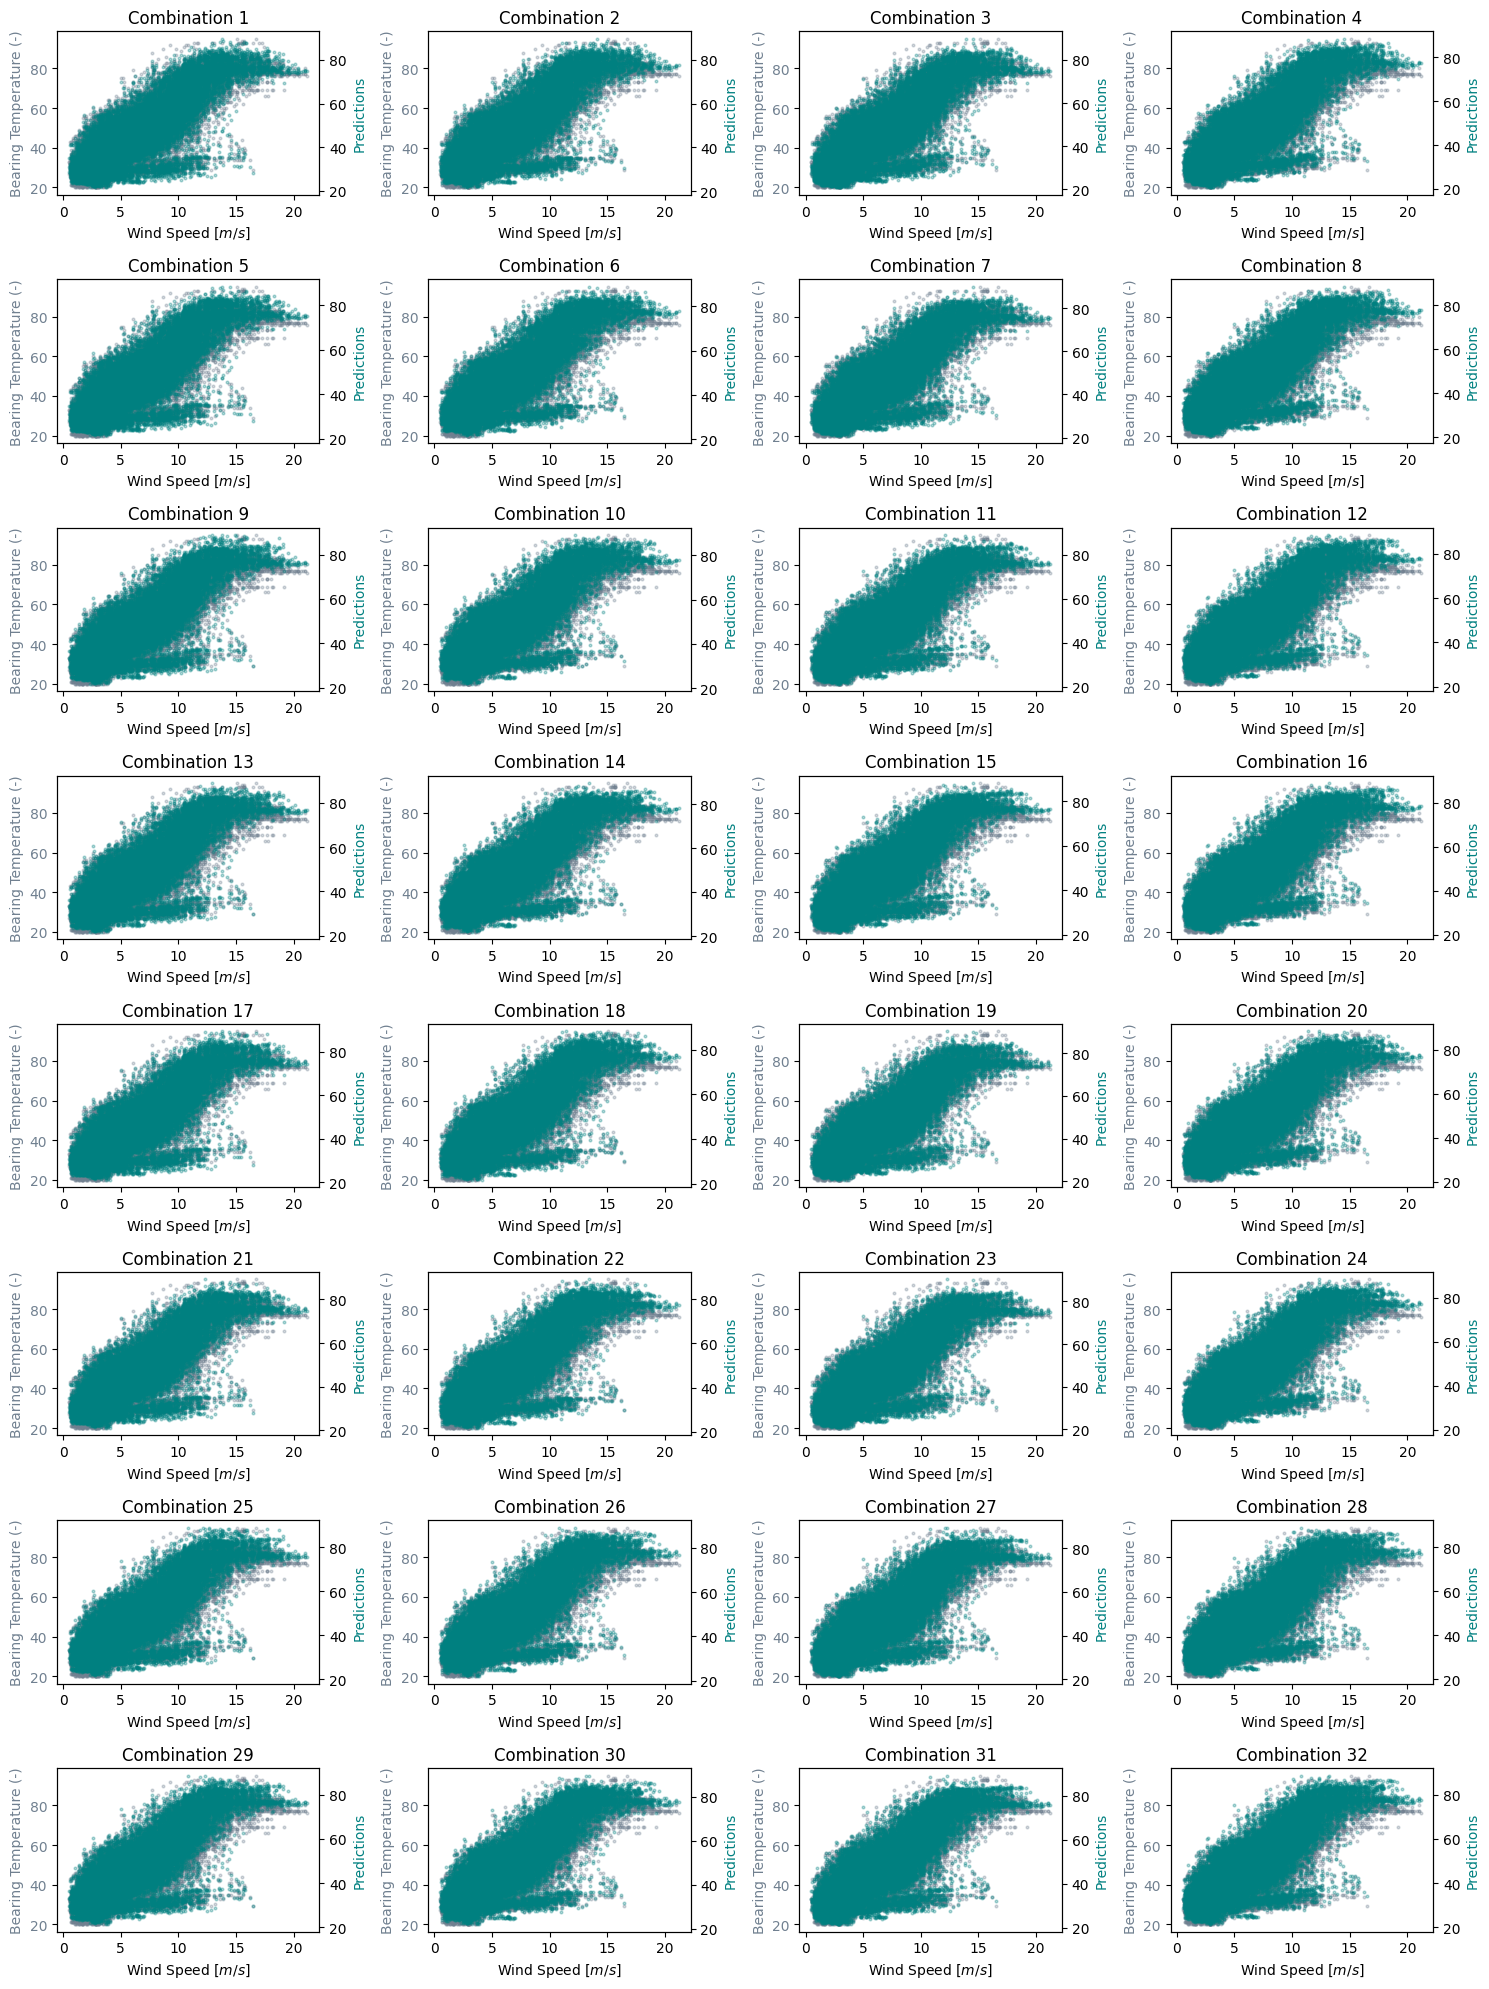

In [36]:
import matplotlib.pyplot as plt

# Plot predictions for all 32 combinations with subplots
fig, axes = plt.subplots(8, 4, figsize=(15, 20))  # 8x4 grid for 32 combinations
axes = axes.flatten()  # Flatten the 2D grid for easy iteration

# Iterate through combinations
for idx, combo in enumerate(combinations):
    humidity_val, Gen_Phase1_Temp_val, Gen_RPM_val, Windspeed_val, Nac_Temp_val = combo

    X_test = pd.DataFrame({
        'Gen_Phase1_Temp_Avg': merged_df_filtered17_sorted["Gen_Phase1_Temp_Avg"] + Gen_Phase1_Temp_val,
        'Gen_RPM_Avg': merged_df_filtered17_sorted["Gen_RPM_Avg"] + Gen_RPM_val,
        'Avg_Windspeed1': merged_df_filtered17_sorted["Avg_Windspeed1"] + Windspeed_val,
        'Nac_Temp_Avg': merged_df_filtered17_sorted["Nac_Temp_Avg"] + Nac_Temp_val,
        'Avg_Humidity': merged_df_filtered17_sorted["Avg_Humidity"] + humidity_val
    })

    # Predict with the model
    predictions = model.predict(X_test)
    merged_df_filtered17_sorted[f'pred_comb_{idx+1}'] = predictions

    ax = axes[idx]
    ax.scatter(merged_df_filtered17_sorted["Amb_WindSpeed_Avg"], merged_df_filtered17_sorted["Gen_Bear_Temp_Avg"],
               color='slategrey', alpha=0.3, marker='.', s=15, label='Temperature actual')
    ax2 = ax.twinx()  # Create a secondary y-axis
    ax2.scatter(merged_df_filtered17_sorted["Amb_WindSpeed_Avg"], predictions,
                color='teal', alpha=0.3, marker='.', s=15, label=f'Pred_comb_{idx+1}')

    ax.set_title(f'Combination {idx+1}')
    ax.set_xlabel('Wind Speed [$m/s$]')
    ax.set_ylabel('Bearing Temperature (-)', color='slategrey')
    ax.tick_params(axis='y', labelcolor='slategrey')
    ax2.set_ylabel('Predictions', color='teal')

# Show the overall plot
plt.tight_layout()
plt.show()


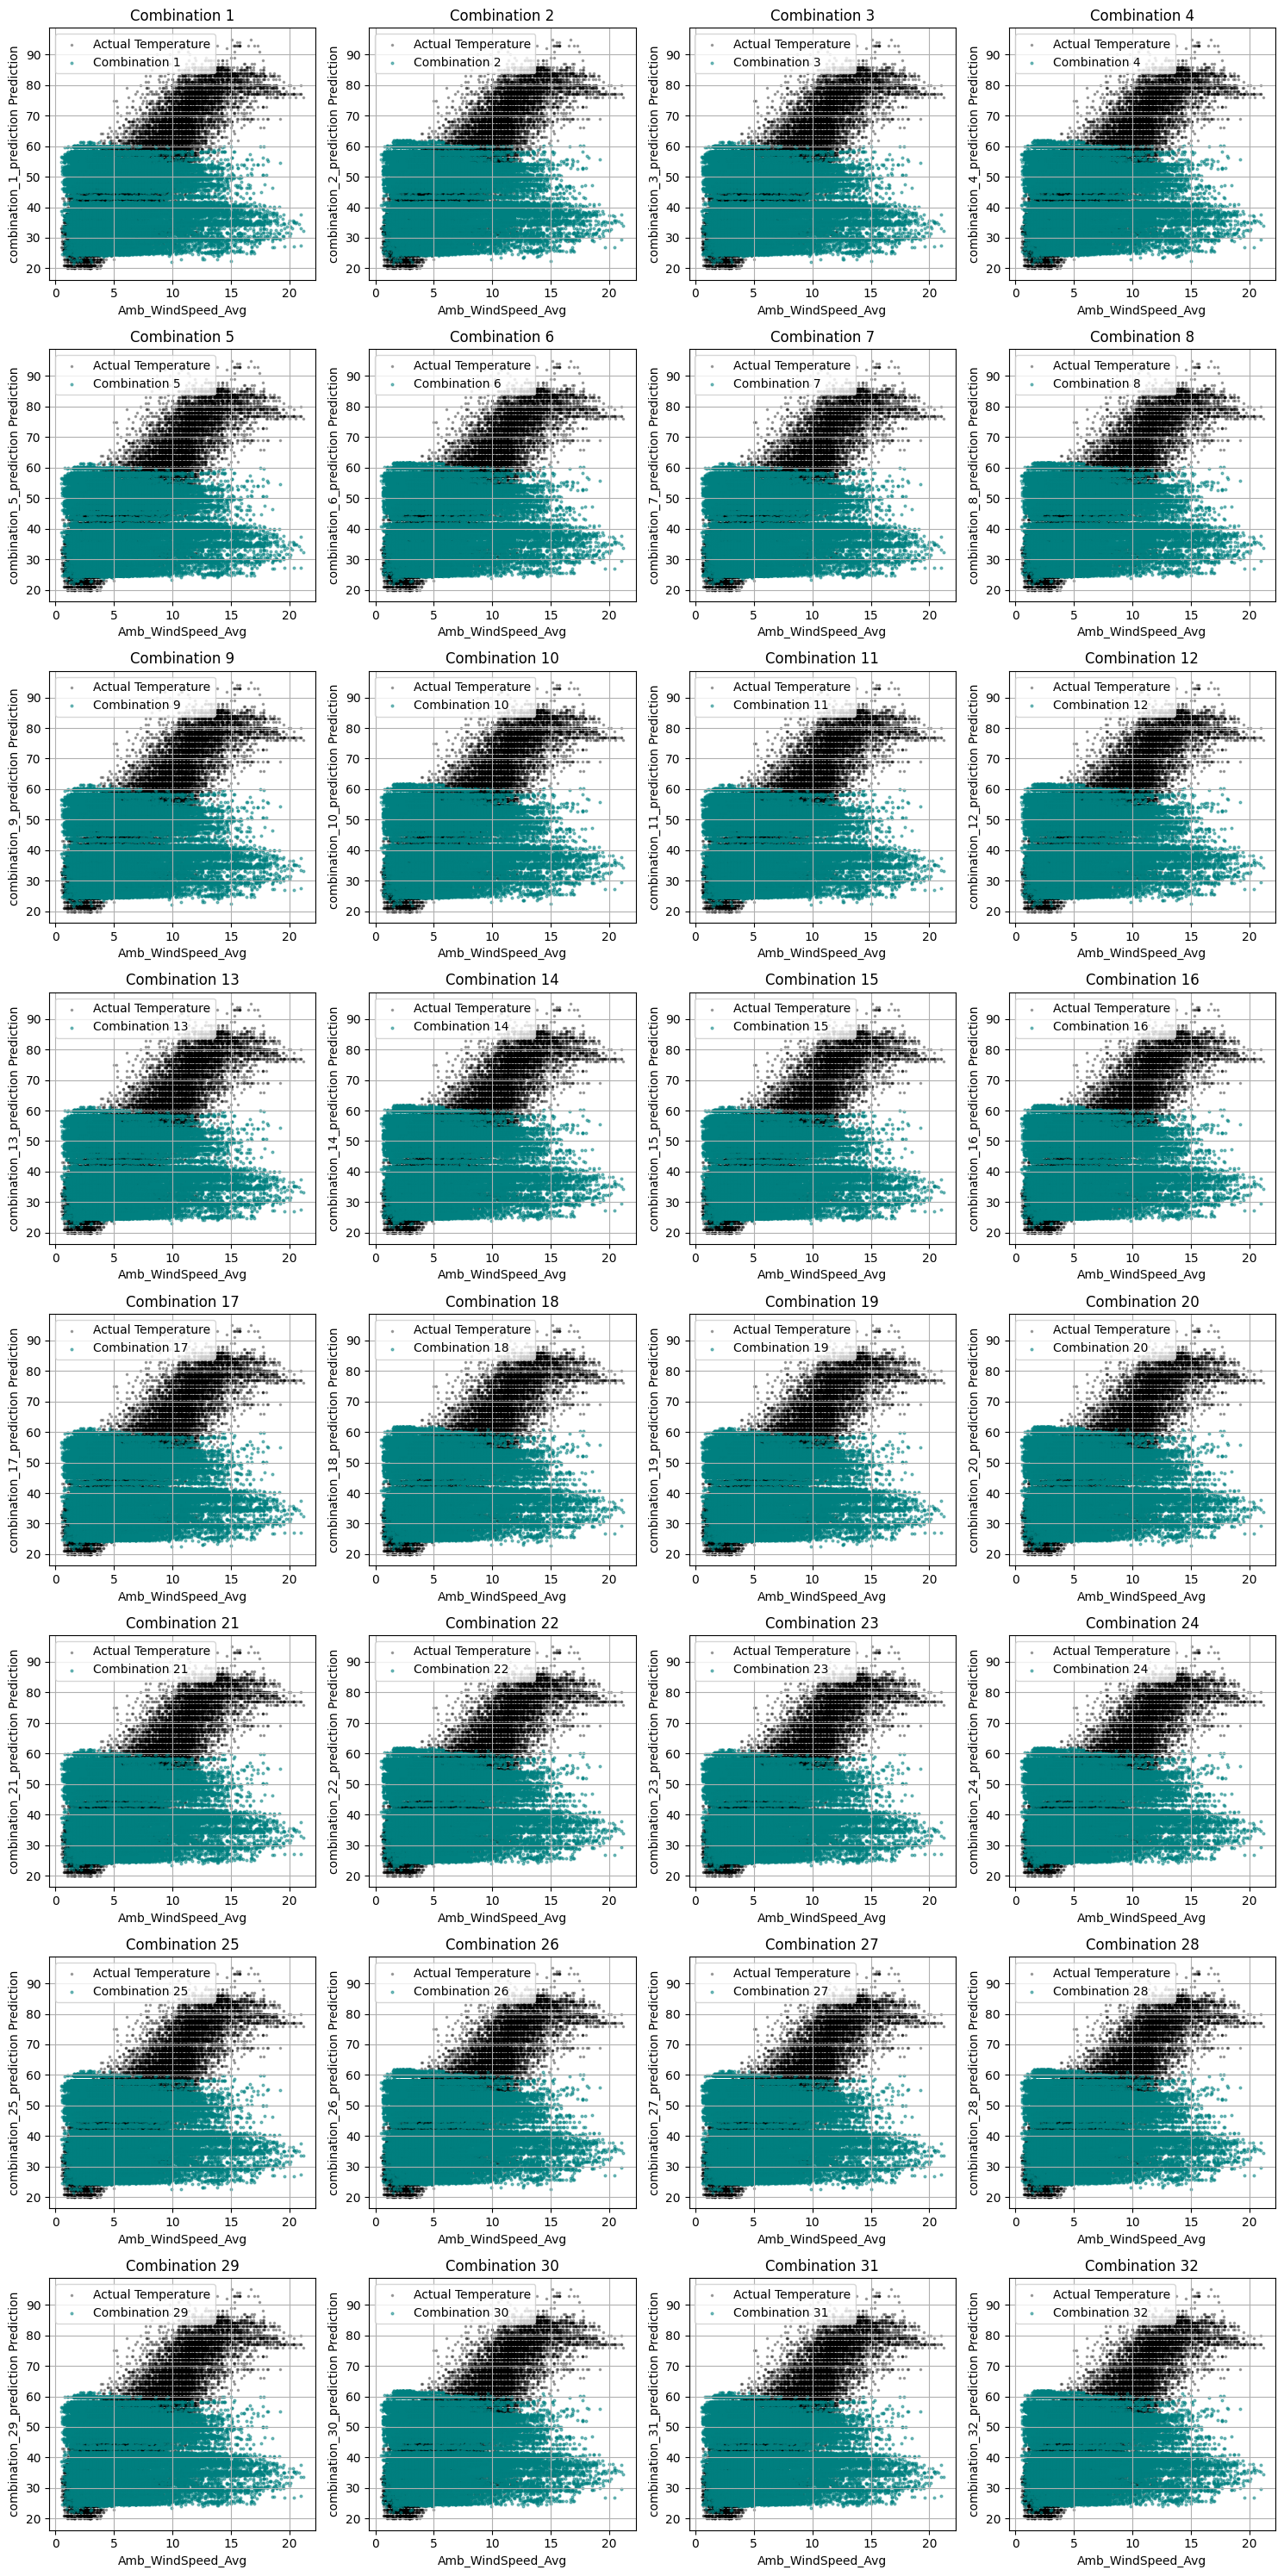

In [24]:
import matplotlib.pyplot as plt

# Number of combinations (32 combinations)
num_combinations = 32

# Set up the plot grid (8x4 grid for 32 subplots)
fig, axes = plt.subplots(8, 4, figsize=(15, 30))

# Flatten the axes array to make indexing easier
axes = axes.flatten()

# Loop through each combination (combination_1, combination_2, ..., combination_32)
for i in range(1, num_combinations + 1):
    # Select the corresponding column name for this combination
    combination_column = f"combination_{i}_prediction"
    
    # Scatter plot of actual temperature in the background
    axes[i - 1].scatter(
        merged_df_filtered17_sorted["Amb_WindSpeed_Avg"], 
        merged_df_filtered17_sorted[target_column], 
        color='black', marker=".", s=10, alpha=0.3, label="Actual Temperature"
    )

    # Scatter plot of Amb_WindSpeed_Avg vs the current combination using matplotlib
    axes[i - 1].scatter(
        merged_df_filtered17_sorted["Amb_WindSpeed_Avg"], 
        merged_df_filtered17_sorted[combination_column], 
        color='teal', marker=".", s=15, alpha=0.5, label=f"Combination {i}"
    )
    
    # Set the title for each subplot
    axes[i - 1].set_title(f"Combination {i}", fontsize=12)
    axes[i - 1].set_xlabel("Amb_WindSpeed_Avg")
    axes[i - 1].set_ylabel(f"{combination_column} Prediction")
    
    # Optionally add grid and legend
    axes[i - 1].grid(True)
    axes[i - 1].legend()

# Adjust the layout
plt.tight_layout()
plt.show()


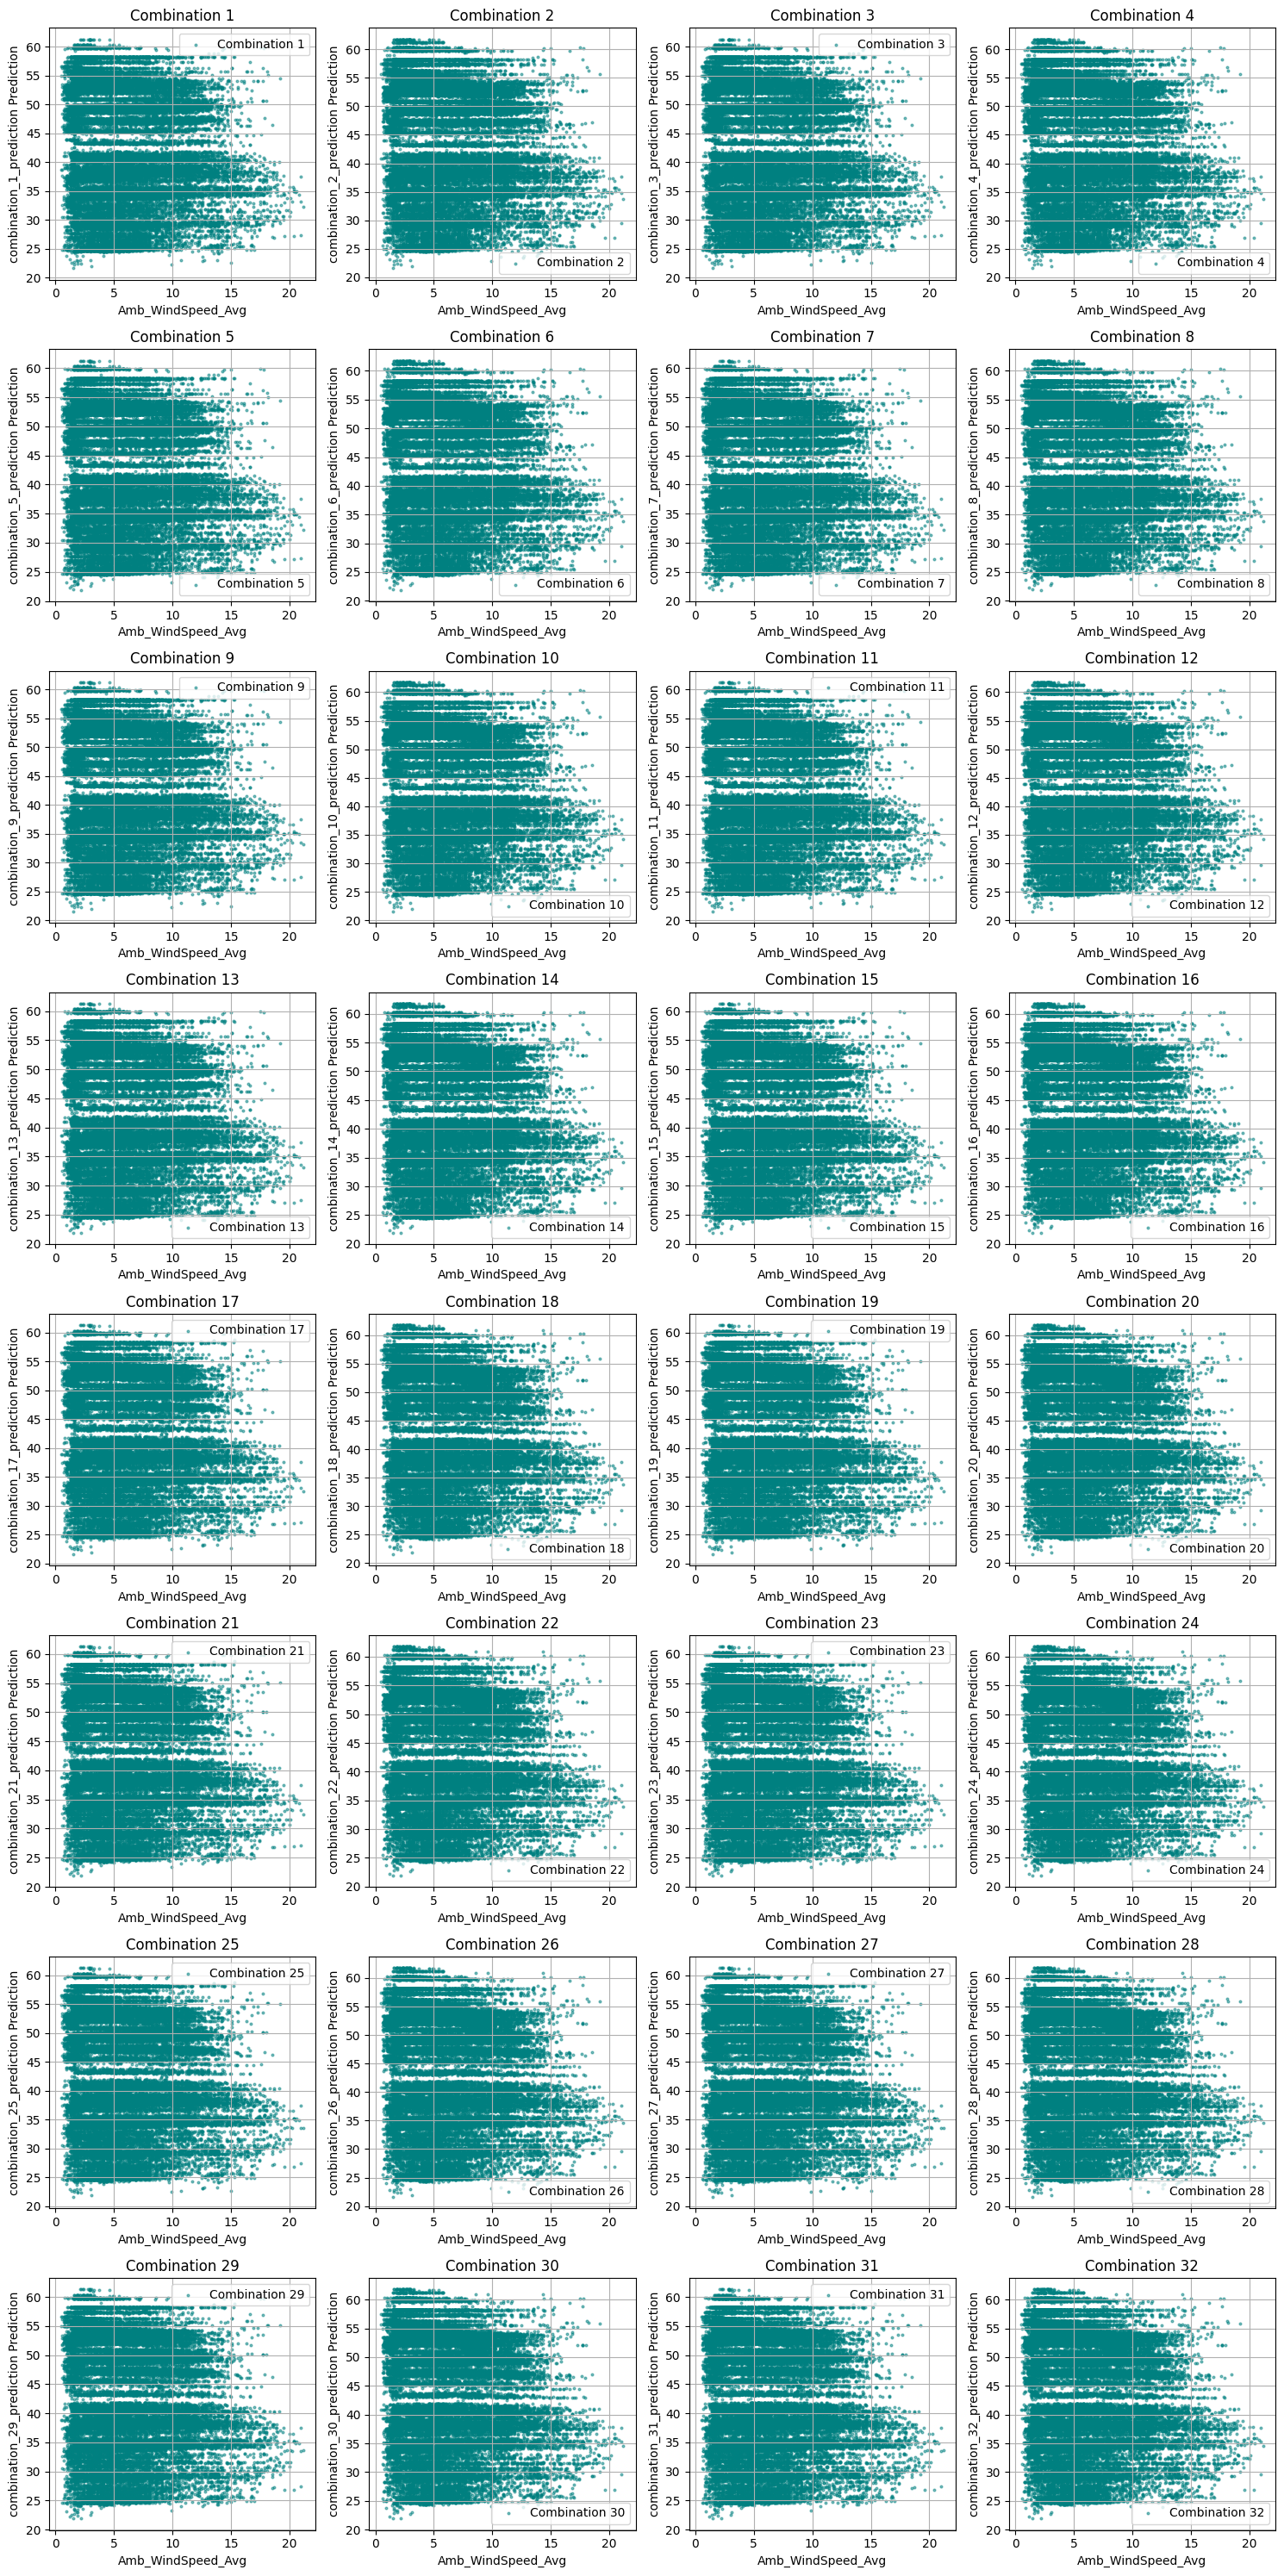

In [25]:
import matplotlib.pyplot as plt

# Number of combinations (32 combinations)
num_combinations = 32

# Set up the plot grid (8x4 grid for 32 subplots)
fig, axes = plt.subplots(8, 4, figsize=(15, 30))

# Flatten the axes array to make indexing easier
axes = axes.flatten()

# Loop through each combination (combination_1, combination_2, ..., combination_32)
for i in range(1, num_combinations + 1):
    # Select the corresponding column name for this combination
    combination_column = f"combination_{i}_prediction"
    
    # Scatter plot of Amb_WindSpeed_Avg vs the current combination using matplotlib
    axes[i - 1].scatter(
        merged_df_filtered17_sorted["Amb_WindSpeed_Avg"], 
        merged_df_filtered17_sorted[combination_column], 
        color='teal', marker=".", s=15, alpha=0.5, label=f"Combination {i}"
    )
    
    # Set the title for each subplot
    axes[i - 1].set_title(f"Combination {i}", fontsize=12)
    axes[i - 1].set_xlabel("Amb_WindSpeed_Avg")
    axes[i - 1].set_ylabel(f"{combination_column} Prediction")
    
    # Optionally add grid and legend
    axes[i - 1].grid(True)
    axes[i - 1].legend()

# Adjust the layout
plt.tight_layout()
plt.show()


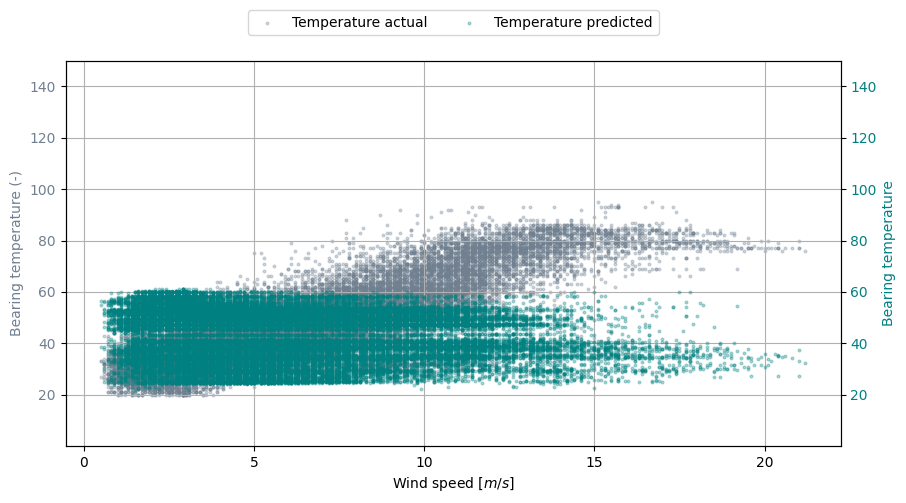

In [28]:
# Adjusted color scheme with burgundy and muted green
fig, ax1 = plt.subplots()  # Create a figure and axis

# Plotting the actual Cp values on the primary y-axis with burgundy
ax1.scatter(merged_df_filtered17_sorted["Amb_WindSpeed_Avg"], merged_df_filtered17_sorted["Gen_Bear_Temp_Avg"], color='slategrey', label='Temperature actual', alpha=0.3, marker='.', s=15)
ax1.set_xlabel('Wind speed [$m/s$]')  # x-axis label
ax1.set_ylabel('Bearing temperature (-)', color='slategrey')  # Primary y-axis label color
ax1.tick_params(axis='y', labelcolor='slategrey')  # Primary y-axis label tick color
ax1.grid()
ax1.set_ylim(0.1, 150)  # Set y-limits for Cp values

# Create a secondary y-axis with a muted green color
ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis
ax2.scatter(merged_df_filtered17_sorted["Amb_WindSpeed_Avg"], merged_df_filtered17_sorted["combination_1_prediction"], color='teal', label='Temperature predicted', alpha=0.3, marker='.', s=15)  # Muted olive green color
ax2.set_ylabel('Bearing temperature', color='teal')  # Secondary y-axis label color
ax2.tick_params(axis='y', labelcolor='teal')  # Secondary y-axis label tick color
ax2.set_ylim(0.1, 150)

# Optional: Add legends for both y-axes with subtle colors
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), bbox_transform=ax1.transAxes, ncol=2)

# Show the plot
plt.show()

In [ ]:
"""import matplotlib.pyplot as plt

# Number of combinations (16 combinations)
num_combinations = 32

# Set up the plot grid (4x4 grid for 16 subplots)
fig, axes = plt.subplots(4, 4, figsize=(15, 15))

# Flatten the axes array to make indexing easier
axes = axes.flatten()

# Loop through each combination (combination_1, combination_2, ..., combination_16)
for i in range(1, num_combinations + 1):
    # Select the corresponding column name for this combination
    combination_column = f"combination_{i}"
    
    # Scatter plot of Amb_WindSpeed_Avg vs the current combination using matplotlib
    axes[i - 1].scatter(
        merged_df_filtered17_sorted["Amb_WindSpeed_Avg"], 
        merged_df_filtered17_sorted[combination_column], 
        color='blue', alpha=0.5, label=f"Combination {i}"
    )
    
    # Set the title for each subplot
    axes[i - 1].set_title(f"Combination {i}", fontsize=12)
    axes[i - 1].set_xlabel("Amb_WindSpeed_Avg")
    axes[i - 1].set_ylabel(f"{combination_column} Prediction")
    
    # Optionally add grid and legend
    axes[i - 1].grid(True)
    axes[i - 1].legend()

# Adjust the layout
plt.tight_layout()
plt.show()
"""

In [ ]:
"""def apply_combination_and_predict(row, combination_config, intervals_dict):
    """
    This function applies the configuration (Min/Max) to the row's features and makes a prediction.
    """
    # Apply the configuration to the row based on the Min/Max values
    for feature, config in combination_config.items():
        if config == "Min":
            # Set the feature to its minimum value (you should replace this with actual logic)
            row[feature] = row[feature] + min(intervals_dict[feature])  # Adjust based on Min value
        elif config == "Max":
            # Set the feature to its maximum value (you should replace this with actual logic)
            row[feature] = row[feature] + max(intervals_dict[feature])  # Adjust based on Max value
    
    # Now predict using the model
    prediction = model.predict([row[feature_columns]])  # Predict for the current row
    return prediction[0]
"""

In [ ]:
"""# Example: intervals_dict is assumed to contain the Min and Max values for each feature
intervals_dict = {
    "Avg_Windspeed1": [-1, 1],  # Example: Adjust this with your actual interval values
    "Gen_Phase1_Temp_Avg": [-1, 1],
    "Avg_Humidity": [-1, 1],
    "Gen_RPM_Avg": [-1, 1],
    "Nac_Temp_Avg": [-1, 1]
}

# Iterate over the combination configurations and make predictions
for combination_num, combination_config in combination_configs.items():
    merged_df_filtered17_sorted[f"combination_{combination_num}"] = merged_df_filtered17_sorted.apply(
        lambda row: apply_combination_and_predict(row, combination_config, intervals_dict), axis=1
    )
"""

In [ ]:
"""# Function to apply the 'Min' and 'Max' configurations to the features and make a prediction
def apply_combination_and_predict(row, combination_config):
    # Create a new row based on the combination configuration
    for feature, config in combination_config.items():
        if config == "Min":
            # Here we adjust the feature to its minimum interval (add your logic for Min)
            row[feature] = row[feature] + min(intervals_dict[feature])  # Adjusting based on Min
        elif config == "Max":
            # Adjust the feature to its maximum interval (add your logic for Max)
            row[feature] = row[feature] + max([feature])  # Adjusting based on Max

    # Now predict using the model
    prediction = model.predict([row[feature_columns]])  # Predict for the current row
    return prediction[0]

# Generate predictions for each combination and store them in new columns
for combination_num, combination_config in combination_configs.items():
    merged_df_filtered17_sorted[f"combination_{combination_num}"] = merged_df_filtered17_sorted.apply(
        lambda row: apply_combination_and_predict(row, combination_config), axis=1
    )
"""